In [1]:
#!pip install cma

In [2]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis

from IPython.display import clear_output
import scipy
import numpy as np

import matplotlib.pyplot as plt

import cma
from qiskit.tools.visualization import plot_histogram
from collections import Counter
from datetime import datetime

import sys, os

In [3]:
class QBM:
    def __init__(self,n,numEigenstates):
        self.n = n
        self.numParameters = int(2*n + n*(n-1)/2)
        self.numEigenstates = numEigenstates
        self.bases = [bin(2**self.n-1-i)[2:].zfill(self.n) for i in range(2**self.n)]
        assert numEigenstates=='all' or numEigenstates <2**n, 'Wrong Number of Eigenstates or not "all"'
        self.numEigenstates = numEigenstates
        
    def perform_epoch(self,HamiltonianParameters):
        self.currentParameters = HamiltonianParameters
        E,V = self.use_quspin(HamiltonianParameters)
        self.eigenenergies = E
        self.calc_weights()
        self.deal_with_eigenstates(E,V)
    
    def deal_with_eigenstates(self,E,V):
        if self.numEigenstates == 'all':
            stateProbs = [V[:,i]**2 for i in range(2**self.n)]
        else:
            stateProbs = [V[:,i]**2 for i in range(self.numEigenstates)]
        
        # select how many shots per eigenstate
        eigenstateRNG = np.random.rand(1000)
        partial = [sum(self.thermalProbs[:i+1]) for i in range(len(self.thermalProbs))]
        chooseState = [next(idx for idx,prob in enumerate(partial) if prob > rng) for rng in eigenstateRNG]
        state, hits = np.unique(chooseState,return_counts=True)
        sampledDict = {}
        for i in range(len(state)):
            # select how many shots per basis state in the eigenstate
            sampleRNG = np.random.rand(100*hits[i])
            statePartial = [sum(stateProbs[i][:j+1]) for j in range(len(stateProbs[i]))]
            chooseBasis = [next(idx for idx,prob in enumerate(statePartial) if prob > rng) for rng in sampleRNG]
            bases, counts = np.unique(chooseBasis,return_counts=True)
            sampledDict = Counter(sampledDict) + Counter({bin(bases[i])[2:].zfill(self.n):counts[i] for i in range(len(bases))})
        self.sampledDict = {base:val/sum(sampledDict.values()) for base,val in sampledDict.items()}
    
    def calc_weights(self):
        if self.numEigenstates == 'all':
            BoltzmannFactors = [np.exp(-energy) for energy in self.eigenenergies]
        else:
            BoltzmannFactors = [np.exp(-energy) for energy in self.eigenenergies[:self.numEigenstates]]
        partitionSum = np.sum(BoltzmannFactors)
        assert partitionSum>0, 'partition Sum not positive'
        self.thermalProbs = [BFactor/partitionSum for BFactor in BoltzmannFactors]
        self.thermalWeights = np.sqrt(self.thermalProbs)
   
    def use_quspin(self,HamiltonianParameters):
        # compute spin-1/2 basis
        basis = spin_basis_1d(self.n,pauli=True)             # simple basis without any symmetries
        
        ### for non-diagonal QBM ###
        hx = HamiltonianParameters[:self.n]
        hz = HamiltonianParameters[self.n:2*self.n]
        J = HamiltonianParameters[2*self.n:]
        # reorder
        J_zz = [0.]*len(J)
        counter = 0
        for i in range(self.n-1):
            for j in range(i+1,self.n):
                J_zz[counter] = [-J[counter],i,j]
                counter += 1
        h_x=[[-hx[i],i] for i in range(self.n)] 
        h_z=[[-hz[i],i] for i in range(self.n)]
        # static and dynamic lists
        static = [["zz",J_zz],["x",h_x],["z",h_z]]
        
        ### for diagonal QBM ###
        '''
        hz = HamiltonianParameters[:self.n]
        J = HamiltonianParameters[self.n:]
        # reorder
        J_zz = [0.]*len(J)
        counter = 0
        for i in range(self.n-1):
            for j in range(i+1,self.n):
                J_zz[counter] = [-J[counter],i,j]
                counter += 1
        h_z=[[-hz[i],i] for i in range(self.n)]
        # static and dynamic lists
        static = [["zz",J_zz],["z",h_z]]
        '''
        dynamic=[]
        # compute the time-independent Heisenberg Hamiltonian
        no_checks={"check_herm":False,"check_pcon":False,"check_symm":False}
        H_XZZZ = hamiltonian(static,dynamic,basis=basis,dtype=np.float64,**no_checks)
        print(H_XZZZ)
        E,V=H_XZZZ.eigh()
                     
        return E,V


In [4]:
#########################################################################
## define model parameters
N=2# number of qubits
numParams = int(2*N + N*(N-1)/2)

J=1.0
g=0.809 # transverse field
h=0.9045 # longitudinal field
basis=spin_basis_1d(N,pauli=True)
# params= np.random.rand(numParams)-0.5a #[first N hz| next n:hx | nC2: h1zh2z]
params = [1,0,0,0,0]
iterations = 100

qbm = QBM(N, 'all')
qbm.use_quspin(params)

static mat: 
  (0, 2)	-1.0
  (1, 3)	-1.0
  (2, 0)	-1.0
  (3, 1)	-1.0


dynamic:



(array([-1., -1.,  1.,  1.]),
 array([[ 0.70710678,  0.        , -0.70710678,  0.        ],
        [ 0.        ,  0.70710678,  0.        , -0.70710678],
        [ 0.70710678,  0.        ,  0.70710678,  0.        ],
        [ 0.        ,  0.70710678,  0.        ,  0.70710678]]))

In [5]:
def train_QBM(HamiltonianParameters,QBM,trainingSet):
    overlapProgress = []
    fitnessProgress = []
    gradientProgress = []
    QBM.perform_epoch(HamiltonianParameters) 
    
    sampleProb = np.zeros(len(trainingSet))
    eps = pow(10,-8)
    t = np.unique(trainingSet,return_counts=True)
    TS = {t[0][i]:t[1][i] for i in range(len(t[0]))}
    ll = []
    ov = []
    for dataSample in TS:
        if dataSample in QBM.sampledDict:
            ll.append(TS[dataSample]/len(trainingSet)*np.log(QBM.sampledDict[dataSample]))
            ov.append(np.sqrt(TS[dataSample]/len(trainingSet)*QBM.sampledDict[dataSample]))
        else:
            ll.append(TS[dataSample]/len(trainingSet)*np.log(eps))
    return -np.sum(ll), np.sum(ov) 

### Generate a binomial training set

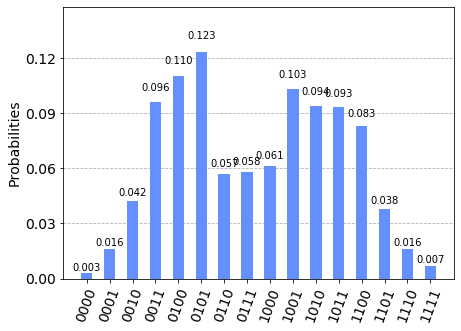

In [6]:
from scipy.stats import binom
def generateSamples(numSamples,p):
    allSamples = []
    for i in range(1):
        data_binom = binom.rvs(n=2**4-1,p=p,loc=0,size=numSamples) # 64 must be changed to 16 if we use 4 qubits 
        x = []
        for i in data_binom:
            x.append('{0:04b}'.format(i))                       # 6 must be changed to a 4 if the use 4 qubits 
    return x

ts = generateSamples(500,0.3)             ## this one is on the left of the tomo
temp = np.unique(ts,return_counts=True)
TS = {temp[0][i]:temp[1][i] for i in range(len(temp[0]))}
ps = generateSamples(500,0.7)             ## this on is in the middle of the tomo
pemp = np.unique(ps,return_counts=True)
PS = {pemp[0][i]:pemp[1][i] for i in range(len(pemp[0]))}

both = list(np.append(ts,ps))          ## this one has both
stemp = np.unique(both,return_counts=True)
trainingDict = {stemp[0][i]:stemp[1][i] for i in range(len(stemp[0]))} 
plot_histogram(trainingDict)


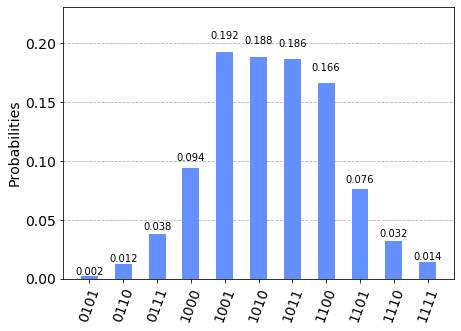

In [7]:
plot_histogram(PS)

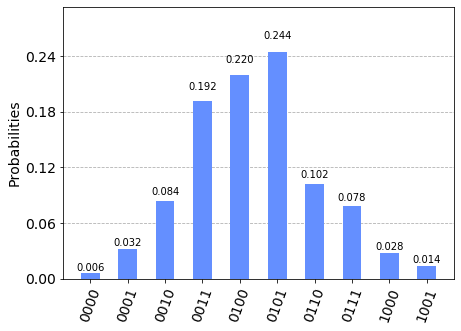

In [8]:
plot_histogram(TS)

### Initialize everything and train

In [9]:
n = 4   # number of qubits
numEigenstates = 'all'   # number of eigenstates, any integer below 2^n or 'all'
## cma-es training paramaters, more is better and slower ##
lamda = 4
mu = 2
numIter = 150
initStep = 0.2
##

##
trainingSet = both   # choose ps, ts, both or any training set you like
print('first 10 samples of training set:',trainingSet[:10])
#numEigenstates = 2


numParams = int(2*n + n*(n-1)/2) # for non-diagonal QBM
#numParams = int(n + n*(n-1)/2)  # for diagonal QBM

initHamiltonianParameters = np.random.rand(numParams)-0.5
####

ovP = []
nllP = []
myQBM = QBM(n,numEigenstates)
es=cma.CMAEvolutionStrategy(initHamiltonianParameters,initStep,
                            {'popsize': lamda,
                            'CMA_mu': mu,
                            'maxiter': numIter,
                            'verb_disp': 20})
lamfunc = lambda hamPars: train_QBM(hamPars,myQBM,trainingSet)
for it in range(numIter):
    solutions = es.ask()
    sols = [lamfunc(x) for x in solutions]
    es.tell(solutions, [sols[i][0] for i in range(len(sols))])
    ovP.append([sols[i][1] for i in range(len(sols))])
    nllP.append([sols[i][0] for i in range(len(sols))])
    es.disp()
        

first 10 samples of training set: ['0101', '0100', '0100', '0011', '0011', '0101', '0011', '0110', '0100', '0110']
mu = 2
(2_w,4mirr1)-aCMA-ES (mu_w=1.5,w_1=80%) in dimension 14 (seed=7853, Sun May  8 15:17:27 2022)
static mat: 
  (0, 0)	-1.3779314759970624
  (0, 1)	0.2994229019747241
  (0, 2)	-0.28393692675092763
  (0, 4)	0.3009348487271377
  (0, 8)	-0.23004901378352033
  (1, 0)	0.2994229019747241
  (1, 1)	1.5620376771280498
  (1, 3)	-0.28393692675092763
  (1, 5)	0.3009348487271377
  (1, 9)	-0.23004901378352033
  (2, 0)	-0.28393692675092763
  (2, 2)	0.5493942267656923
  (2, 3)	0.2994229019747241
  (2, 6)	0.3009348487271377
  (2, 10)	-0.23004901378352033
  (3, 1)	-0.28393692675092763
  (3, 2)	0.2994229019747241
  (3, 3)	1.7862196290443415
  (3, 7)	0.3009348487271377
  (3, 11)	-0.23004901378352033
  (4, 0)	0.3009348487271377
  (4, 4)	-0.9694824354734705
  (4, 5)	0.2994229019747241
  (4, 6)	-0.28393692675092763
  (4, 12)	-0.23004901378352033
  :	:
  (11, 3)	-0.23004901378352033
  (11, 9)

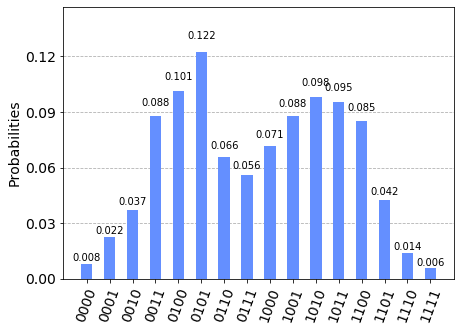

In [10]:
overlapProgress = np.mean(ovP,axis=1)
fitnessProgress = np.mean(nllP,axis=1)

plot_histogram(myQBM.sampledDict)

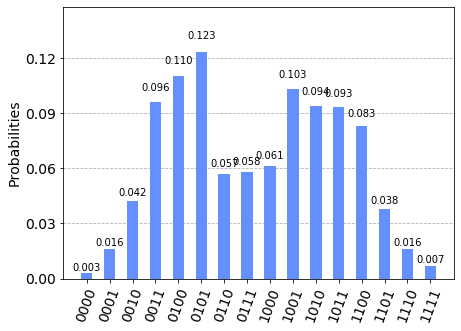

In [11]:
plot_histogram(trainingDict)

### Plot the Training Progress

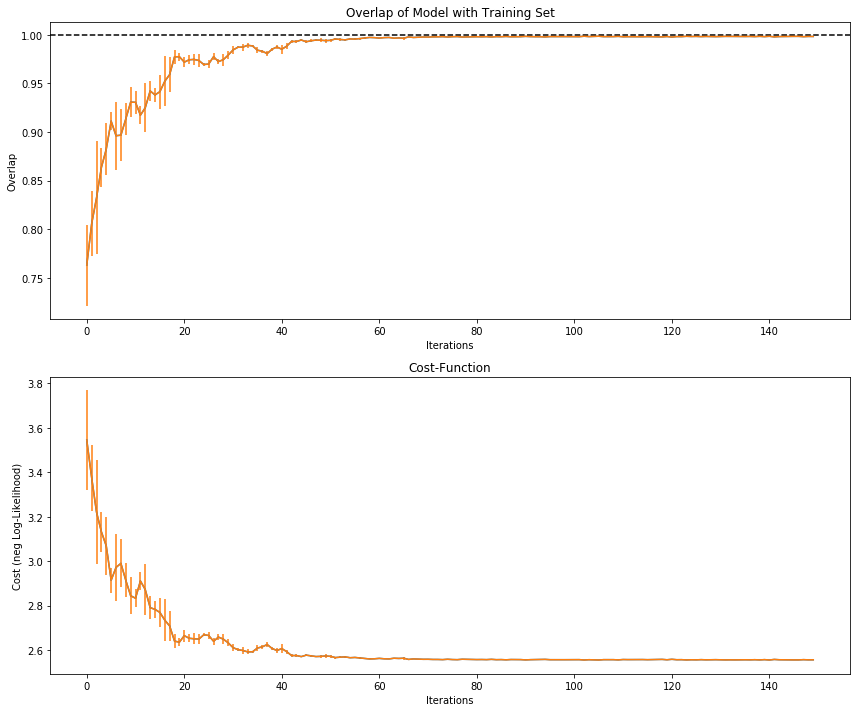

In [12]:
plt.figure(figsize=(12,10))
### 
plt.subplot(2,1,1)
plt.title('Overlap of Model with Training Set')
plt.ylabel('Overlap')
plt.xlabel('Iterations')
plt.plot(np.arange(numIter),overlapProgress)
plt.errorbar(np.arange(numIter),overlapProgress,yerr=np.std(ovP,axis=1))
plt.axhline(y=1,color='black', linestyle='--')
 
plt.subplot(2,1,2)
plt.title('Cost-Function')
plt.ylabel('Cost (neg Log-Likelihood)')
plt.xlabel('Iterations')
plt.plot(np.arange(numIter),fitnessProgress)
plt.errorbar(np.arange(numIter),fitnessProgress,yerr=np.std(nllP,axis=1))

plt.tight_layout()
plt.show()